In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
#read in all words
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [3]:
#build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
string_to_index = {s:i+1 for i,s in enumerate(chars)}
string_to_index['.'] = 0
index_to_string = {i:s for s,i in string_to_index.items()}
vocab_size = len(index_to_string)
print(vocab_size)
print(index_to_string)

27
{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [4]:
import random
random.seed(42)
random.shuffle(words)

In [74]:
#split dataset to train, dev/val, test
#build dataset
block_size = 8 #context length: how many characters do we take to predict the next one
def build_dataset(words):
    
    X, Y = [], [] 
    
    for w in words:
        #print(w)
        context = [0] * block_size # [0, 0, 0]
        for ch in w + '.':
            ix = string_to_index[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix] #crop and append
    
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])  #80%
Xdev, Ydev = build_dataset(words[n1:n2]) #10%
Xte, Yte = build_dataset(words[n2:]) #10%

torch.Size([182625, 8]) torch.Size([182625])
torch.Size([22655, 8]) torch.Size([22655])
torch.Size([22866, 8]) torch.Size([22866])


In [75]:
for x,y in zip(Xtr[:20], Ytr[:20]):
    print(''.join(index_to_string[ix.item()] for ix in x), '---->', index_to_string[y.item()])

........ ----> y
.......y ----> u
......yu ----> h
.....yuh ----> e
....yuhe ----> n
...yuhen ----> g
..yuheng ----> .
........ ----> d
.......d ----> i
......di ----> o
.....dio ----> n
....dion ----> d
...diond ----> r
..diondr ----> e
.diondre ----> .
........ ----> x
.......x ----> a
......xa ----> v
.....xav ----> i
....xavi ----> e


In [204]:
# https://docs.pytorch.org/docs/stable/nn.html
# https://docs.pytorch.org/docs/stable/generated/torch.nn.Linear.html
class Linear:
    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out), generator=g) / fan_in**0.5
        self.bias = torch.zeros(fan_out) if bias else None

    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out

    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])

# https://docs.pytorch.org/docs/stable/generated/torch.nn.BatchNorm1d.html
class BatchNorm1d:

    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        #parameters (trained with backprop)
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        #buffers (trained with a running 'momentum update')
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)

    def __call__(self, x):
        #calculate the forward pass
        if self.training:
            if x.ndim == 2:
                dim = 0
            elif x.ndim == 3:
                dim = (0,1)
            xmean = x.mean(dim, keepdim = True) #batch mean
            xvar = x.var(dim, keepdim = True, unbiased = True) #batch variance
        else:
            xmean = self.running_mean
            xvar = self.running_var
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps) #normalize to unit variance
        self.out = self.gamma * xhat + self.beta
        #update buffers
        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
        return self.out

    def parameters(self):
        return [self.gamma, self.beta]

class Tanh:

    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    def parameters(self):
        return []

class Embedding:

    def __init__(self, num_embeddings, embeddings_dim):
        self.weight = torch.randn((num_embeddings, embeddings_dim))

    def __call__(self, IX):
        self.out = self.weight[IX]
        return self.out

    def parameters(self):
        return [self.weight]

class FlattenConsecutive:

    def __init__(self, n):
        self.n = n

    def __call__(self, x):
        B, T, C = x.shape
        # https://docs.pytorch.org/docs/stable/generated/torch.squeeze.html
        x = x.view(B, T//self.n, C*self.n)
        if x.shape[1] == 1:
            x = x.squeeze(1) #only first dimension
        self.out = x
        return self.out

    def parameters(self):
        return []

class Sequential:

    def __init__(self, layers):
        self.layers = layers

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        self.out = x
        return self.out

    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]


In [205]:
torch.manual_seed(42)

In [213]:
n_embd = 24 #the dimensionality of the character embedding vectors
n_hidden = 128 # the number of neurons in the hidden layer of the MLP
g = torch.Generator().manual_seed(2147483647)

#C = torch.randn((vocab_size, n_embd), generator=g)
model = Sequential([
    Embedding(vocab_size, n_embd),
    FlattenConsecutive(2),Linear(n_embd * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    FlattenConsecutive(2),Linear(n_hidden * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    FlattenConsecutive(2),Linear(n_hidden * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(         n_hidden, vocab_size), 
])

with torch.no_grad():
    #last layer: make less confident
    layers[-1].weight *= 0.1

parameters = model.parameters()
print(sum(p.nelement() for p in parameters))  #number of parameters in total
for p in parameters:
    p.requires_grad = True

76579


In [189]:
ix = torch.randint(0, Xtr.shape[0], (4,)) #let's look at a batch of just 4 examples
#print(ix)
#print(Xtr[1])
Xb, Yb = Xtr[ix], Ytr[ix]
logits = model(Xb)
#print(logits)
print(Xb.shape)
Xb

torch.Size([4, 8])


tensor([[ 0,  0,  0,  0,  0,  0,  0, 13],
        [ 0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0, 20,  8,  9,  5, 18],
        [ 0,  0,  0,  0,  5, 18,  9, 25]])

In [190]:
for layer in model.layers:
    print(layer.__class__.__name__, ':', tuple(layer.out.shape))

Embedding : (4, 8, 10)
FlattenConsecutive : (4, 4, 20)
Linear : (4, 4, 200)
BatchNorm1d : (4, 4, 200)
Tanh : (4, 4, 200)
FlattenConsecutive : (4, 2, 400)
Linear : (4, 2, 200)
BatchNorm1d : (4, 2, 200)
Tanh : (4, 2, 200)
FlattenConsecutive : (4, 400)
Linear : (4, 200)
BatchNorm1d : (4, 200)
Tanh : (4, 200)
Linear : (4, 27)


In [145]:
print(model.layers[0].out[0])
print(model.layers[0].out[0][0])
print(model.layers[0].weight[0])
print(model.layers[0].weight[[ 0,  0,  0,  0,  0,  0,  0, 25]].shape)
print(model.layers[0].weight[torch.tensor([[ 0,  0,  0,  0,  0,  0,  0, 25], [ 0,  2, 18,  5,  3, 11,  9, 14]])].shape)
model.layers[0].out.shape #output of Embedding Layer

tensor([[ 6.8383e-01,  7.3686e-01, -3.0821e-01, -7.2073e-01,  2.0245e-01,
         -5.2213e-01,  8.0496e-02, -5.0289e-01, -4.6575e-01,  1.3761e+00],
        [ 6.8383e-01,  7.3686e-01, -3.0821e-01, -7.2073e-01,  2.0245e-01,
         -5.2213e-01,  8.0496e-02, -5.0289e-01, -4.6575e-01,  1.3761e+00],
        [ 6.8383e-01,  7.3686e-01, -3.0821e-01, -7.2073e-01,  2.0245e-01,
         -5.2213e-01,  8.0496e-02, -5.0289e-01, -4.6575e-01,  1.3761e+00],
        [-9.6940e-01,  1.2900e+00, -2.1345e+00, -1.9375e+00,  3.5950e-01,
          1.3945e+00,  6.0531e-01, -1.5914e+00,  4.0242e-01, -8.5061e-01],
        [ 2.7088e-01, -1.1975e+00, -1.2592e+00, -5.1415e-01, -1.3731e+00,
          5.9262e-01,  3.3802e-01, -1.5248e-01, -8.5132e-01,  1.7930e+00],
        [ 1.7895e+00,  1.1240e-01, -3.8975e-01,  5.5820e-01,  6.3107e-01,
          2.5790e-01, -1.3949e+00,  1.5304e+00, -1.8223e+00, -8.6080e-06],
        [-9.9895e-01,  9.4607e-01, -2.6964e-02,  1.0392e-01, -9.7213e-01,
          1.7589e+00, -7.4460e-0

torch.Size([4, 8, 10])

In [141]:
model.layers[1].out.shape #output of Flatten layer

torch.Size([4, 80])

In [142]:
model.layers[2].out.shape #output of Linear Layer

torch.Size([4, 200])

In [143]:
print((torch.randn(4,80) @ torch.randn(80,200) + torch.randn(200)).shape)
print((torch.randn(4,2,5,80) @ torch.randn(80,200) + torch.randn(200)).shape)

torch.Size([4, 200])
torch.Size([4, 2, 5, 200])


In [147]:
# [1,2,3,4,5,6,7,8] -> ix but as we can see we can flatten out our matrix 
# (1 2) (3 4) (5 6) (7 8)
# (1 2) => [[encoding representation], [second encoding representation]] in total 20 numbers
print((torch.randn(4,4,20) @ torch.randn(20,200) + torch.randn(200)).shape)

torch.Size([4, 4, 200])


In [171]:
l = range(10)
print(list(l))
print(list(l[1::2]))
print(list(l[::2]))
l = torch.tensor(l)
torch.cat([l[::2], l[1::2]])

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
[1, 3, 5, 7, 9]
[0, 2, 4, 6, 8]


tensor([0, 2, 4, 6, 8, 1, 3, 5, 7, 9])

In [177]:
e = torch.randn(2, 8, 10) # goal: want this to be (4, 4, 20) where consecutive 10-d vectors get concatanetaded
explicit = torch.cat([e[:,::2,:], e[:,1::2,:]])
print(explicit)
print(explicit.shape)
explicit = torch.cat([e[:,::2,:], e[:,1::2,:]], dim = 2)
print(explicit)
print(explicit.shape)

tensor([[[-0.1256,  1.1411, -0.5534,  0.1494, -1.6391, -1.0311,  0.0244,
          -0.3528, -0.3469, -0.7101],
         [ 1.3940, -1.3334,  0.8633, -0.7677,  1.5911,  0.7664, -2.7112,
          -1.6605, -0.3403, -0.3539],
         [ 0.6926,  0.5723,  0.2361,  0.7997,  1.0390,  0.4556, -0.3228,
           1.0806, -1.3061,  1.9364],
         [-0.2249,  0.2732, -0.5838,  1.3974, -0.4989, -0.7314, -0.9112,
           0.6607,  0.3699,  0.0052]],

        [[-0.1927,  0.6082, -0.6906,  0.8168,  0.2333,  1.7219, -0.5113,
          -2.1089,  0.7428, -1.1209],
         [-0.9848, -0.1671,  0.3195,  0.2383,  0.8119,  1.7226,  0.7561,
          -0.3193, -0.7612, -0.0830],
         [-0.2859,  0.3865, -0.0912, -0.1635,  1.2272,  1.1136, -0.1722,
           1.2209, -0.6664, -1.6641],
         [-1.6069,  1.4307,  0.4980,  0.1562,  0.0426, -0.2843,  0.8236,
          -2.7073, -0.1502,  1.0638]],

        [[-0.7002,  0.4031, -0.8074,  0.6946, -0.4626, -0.1949, -0.6586,
          -0.0243,  0.4701, -0.3000

In [178]:
(e.view(e.shape[0],-1,20) == explicit).all()

tensor(True)

In [198]:
#batch normalization bug after Flatten Consecutive change
#now the batch it's receiving a three dimension tuple (32, 4, 68)
#when it was expecting 2 dimension, this kind of work by the forcasting doing in the correct other
#but our running_mean and running_std it's not being update correctly
e = torch.randn(32, 4, 68)
emean = e.mean(0, keepdim = True)
evar = e.var(0, keepdim = True)
ehat = (e - emean) / torch.sqrt(evar + 1e-5)
ehat.shape

torch.Size([32, 4, 68])

In [199]:
model.layers[3].running_mean.shape

torch.Size([1, 4, 68])

In [202]:
#so we expect that the mean it's flatten for all values correctly, so we need to tell torch to
#take both first dimmensions
e = torch.randn(32, 4, 68)
emean = e.mean((0,1), keepdim = True)
evar = e.var((0,1), keepdim = True)
ehat = (e - emean) / torch.sqrt(evar + 1e-5)
print(ehat.shape)
print(emean.shape)

torch.Size([32, 4, 68])
torch.Size([1, 1, 68])


In [214]:
#same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []
ud = []

for i in range(max_steps):
    #minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator = g)
    Xb,Yb = Xtr[ix], Ytr[ix] #batch X, Y
    
    #forwardpass
    logits = model(Xb)
    loss = F.cross_entropy(logits, Yb) #loss function

    #backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    #update
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad

    #track stats
    if i % 10000 == 0:
        print(f"{i:7d}/{max_steps:7d}: {loss.item():.4f}")
    lossi.append(loss.log10().item())
    #if i > 1000:
    #  break #AFTER_DEBUG: would take out obviously to run full optimization

      0/ 200000: 3.2847
  10000/ 200000: 1.8382
  20000/ 200000: 1.7571
  30000/ 200000: 1.9980
  40000/ 200000: 2.0007
  50000/ 200000: 1.9487
  60000/ 200000: 2.2822
  70000/ 200000: 1.7536
  80000/ 200000: 1.7307
  90000/ 200000: 2.4759
 100000/ 200000: 2.2135
 110000/ 200000: 1.3182
 120000/ 200000: 1.6682
 130000/ 200000: 1.9666
 140000/ 200000: 1.7168
 150000/ 200000: 1.7833
 160000/ 200000: 1.6866
 170000/ 200000: 1.8370
 180000/ 200000: 2.6336
 190000/ 200000: 1.3715


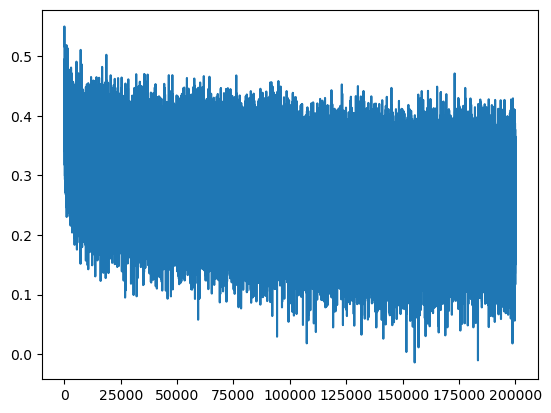

In [215]:
plt.plot(lossi)

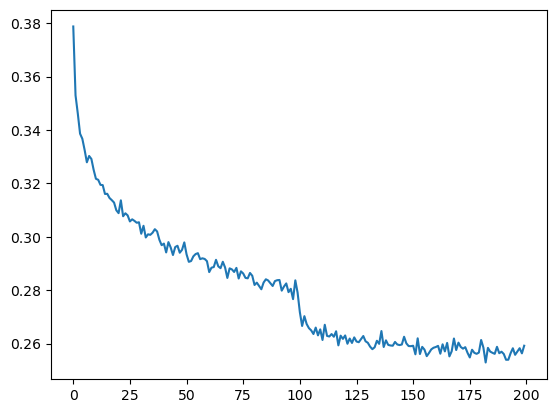

In [216]:
plt.plot(torch.tensor(lossi).view(-1, 1000).mean(1))

In [217]:
#put layers into eval mode
for layer in model.layers:
    layer.training = False

In [218]:
#https://docs.pytorch.org/docs/stable/generated/torch.no_grad.html
@torch.no_grad() # this decorator disable gradient tracking
def split_loss(split):
    x, y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte),
    }[split]
    logits = model(x)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())
split_loss('train')
split_loss('val')

train 1.7833023071289062
val 1.990742564201355


In [219]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      # forward pass the neural net
      logits = model(torch.tensor([context]))
      probs = F.softmax(logits, dim=1)
      # sample from the distribution
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      # shift the context window and track the samples
      context = context[1:] + [ix]
      out.append(ix)
      # if we sample the special '.' token, break
      if ix == 0:
        break
    
    print(''.join(index_to_string[i] for i in out)) # decode and print the generated word

carmah.
amillia.
fismon.
reevy.
skarlete.
rahier.
deliyah.
kaeli.
nelmari.
chaiib.
kaleigh.
hamseon.
desire.
sulina.
livian.
waverly.
jaryn.
karmen.
duran.
edderick.


Why convolutions ? Brief preview/hint

In [233]:
for x,y in zip(Xtr[7:15], Ytr[7:15]):
    print(''.join(index_to_string[ix.item()] for ix in x), '---->', index_to_string[y.item()])

........ ----> d
.......d ----> i
......di ----> o
.....dio ----> n
....dion ----> d
...diond ----> r
..diondr ----> e
.diondre ----> .


In [232]:
#forward a single example:
logits = model(Xtr[[7]])
logits.shape

torch.Size([1, 27])

In [234]:
#forward all of them
logits = torch.zeros(8, 27)
for i in range(8):
    logits[i] = model(Xtr[[7+i]])
logits.shape

torch.Size([8, 27])

In [235]:
#convolution is a "for loop"
# allows us to forward Linear layers efficiently over space